# 4 hidden dimensions - more modes

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

from physics_mi.utils import set_all_seeds

In [2]:
seed = np.random.randint(1, 2**32 - 1)
# seed = 2694658690
set_all_seeds(seed)
print(seed)

300826287


seeds of note:
- `837377100` - 0.0004

## Model

Keeping this extremely simple

In [3]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(self, use_act=True, dim=32, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(2, dim, use_act=use_act),
            LinearLayer(dim, 1, use_act=False),
        )

    def forward(self, x):
        return self.layers(x)

## Data

Going to sample $x_1$ (mass) and $x_2$ (acceleration) such that their product is uniformly distributed.

In [4]:
eps = 0.5

Y = torch.rand(10000)
X = torch.empty(10000, 2)
X[:, 0] = Y / (torch.rand(10000) * (1 - eps) + eps)
X[:, 1] = Y / X[:, 0]

# need to randomly swap x1 and x2 so that they're identically distributed - can do this because their product is commutative
mask = torch.rand(10000) < 0.5
swap_vals = X[:, 0][mask]
X[:, 0][mask] = X[:, 1][mask]
X[:, 1][mask] = swap_vals

assert torch.allclose(X[:, 0] * X[:, 1], Y)

Y = Y[:, None]
X.shape, Y.shape

(torch.Size([10000, 2]), torch.Size([10000, 1]))

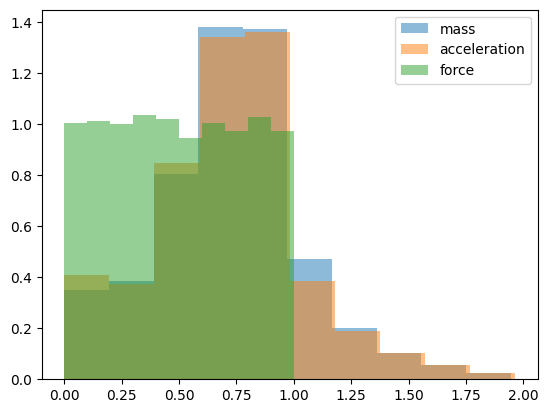

In [5]:
fig, ax = plt.subplots()

ax.hist(X[:, 0], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 1], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 0], alpha=0.5, density=True, label="force")
ax.legend()

In [6]:
s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

X_train = X[s_inds[:8000]]
Y_train = Y[s_inds[:8000]]
X_valid = X[s_inds[8000:]]
Y_valid = Y[s_inds[8000:]]

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

(torch.Size([8000, 2]),
 torch.Size([8000, 1]),
 torch.Size([2000, 2]),
 torch.Size([2000, 1]))

## Training

I'll just do full gradient descent to keep things simple.

In [7]:
N = 4000  # number of epochs

model = Net(use_act=True, dim=4)
loss_func = nn.MSELoss()
optimiser = Adam(model.parameters(), lr=1e-2)
log = []

for i in tqdm(range(N)):
    log_sample = {}

    # Training update
    model.train()
    model.zero_grad()
    Y_hat = model(X_train)
    loss = loss_func(Y_hat, Y_train)
    log_sample["train_loss"] = float(loss.detach())
    loss.backward()
    optimiser.step()

    # Validation set
    model.eval()
    Y_hat = model(X_valid)
    loss = loss_func(Y_hat, Y_valid)
    log_sample["valid_loss"] = float(loss.detach())

    log.append(log_sample)

df = pd.DataFrame(log)

  0%|          | 0/4000 [00:00<?, ?it/s]

## Results

In [8]:
def plot_loss(train_loss, valid_loss):
    _, ax = plt.subplots()

    ax.plot(train_loss, label="train")
    ax.plot(valid_loss, label="valid")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()


def get_preds(model):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.flatten().numpy()
    y_targs = Y_valid.flatten().numpy()

    return y_preds, y_targs


def get_valid_loss(model, loss_func):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    return loss_func(out, Y_valid)


def plot_results(y_preds, y_targs):
    _, ax = plt.subplots()

    ax.scatter(y_preds, y_targs, s=4, label="predictions")
    ax.plot(y_targs, y_targs, color="salmon", ls="--", lw=0.5, label="perfect accuracy")
    ax.set(xlabel="y_preds", ylabel="y_targs")
    ax.legend()

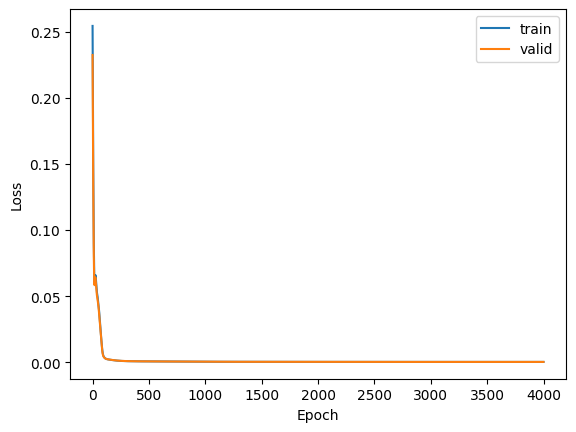

In [9]:
plot_loss(df["train_loss"], df["valid_loss"])

In [10]:
y_preds, y_targs = get_preds(model)

In [11]:
get_valid_loss(model, loss_func)

tensor(0.0004)

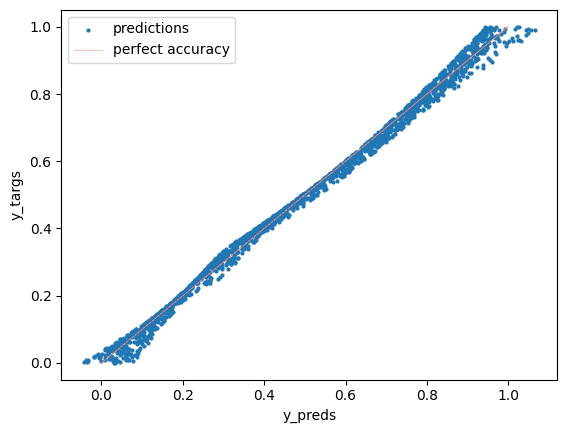

In [12]:
plot_results(y_preds, y_targs)

## Introspection

In [13]:
model

Net(
  (layers): Sequential(
    (0): LinearLayer(
      (linear): Linear(in_features=2, out_features=4, bias=True)
      (act): ReLU()
    )
    (1): LinearLayer(
      (linear): Linear(in_features=4, out_features=1, bias=True)
    )
  )
)

In [14]:
for name, param in model.named_parameters():
    print(name, "\n", param.data, "\n")

layers.0.linear.weight 
 tensor([[-0.2395, -0.3546],
        [ 0.5653,  0.5646],
        [ 0.6435,  1.7919],
        [-0.9491,  0.9675]]) 

layers.0.linear.bias 
 tensor([-0.2799, -0.7026, -0.2863, -0.0046]) 

layers.1.linear.weight 
 tensor([[ 0.0729,  0.6036,  0.3794, -0.4472]]) 

layers.1.linear.bias 
 tensor([-0.0661]) 



### Inspect intermediate values

In [15]:
SD = model.state_dict()

In [16]:
from collections import OrderedDict
import torch
import torch.nn as nn


def capture_intermediate_outputs(model, input_tensor):
    """
    Captures the intermediate outputs of a PyTorch model.

    Args:
        model: A PyTorch model.
        input_tensor: A PyTorch tensor of shape (batch_size, *).
    Returns:
        A dictionary mapping layer names to intermediate outputs.
    """
    intermediate_values = OrderedDict()

    def hook_fn(module, input, output, name):
        if isinstance(module, nn.Linear):
            weight = module.weight
            input_value = input[0]
            intermediate_output = input_value.matmul(weight.t())
            intermediate_values[f"{name}.weight"] = intermediate_output
            intermediate_values[f"{name}.bias"] = output
        else:
            intermediate_values[name] = output

    hooks = []
    for name, layer in model.named_modules():
        hook = layer.register_forward_hook(
            lambda module, input, output, name=name: hook_fn(module, input, output, name)
        )
        hooks.append(hook)

    with torch.inference_mode():
        _ = model(input_tensor)

    for hook in hooks:
        hook.remove()

    filtered_values = {k: t for k, t in intermediate_values.items() if len(k.split(".")) > 2}
    return filtered_values


# a function that uses capture_intermediate_outputs to give a nice printed summary of the model outputs and parameters
def print_model_summary(model, input_tensor):
    intermediate_values = capture_intermediate_outputs(model, input_tensor)

    for k, v in intermediate_values.items():
        print(f"{k}: {v}")

In [17]:
def plot_model_breakdown(
    x1, x2, dim1, dim2, point_selector, ax=None, legend=True, color=None, product_color=False, lines=True
):
    """
    Plots the breakdown of a model's output into its intermediate components.

    Args:
        x1: The first input value.
        x2: The second input value.
        point_selector: A dictionary mapping layer names to booleans. If a layer name is in the dictionary, then the corresponding point will be plotted.
        ax: A matplotlib axes object.
        legend: Whether to show the legend.
        color: The color of the points.
        product_color: Whether to color the points by the product of x1 and x2.
        lines: Whether to draw lines between the points.
    Returns:
        The matplotlib axes object.
    """
    if not ax:
        fig = plt.figure()
        ax = plt.axes()

    input = (x1, x2)

    if not color and product_color:
        val = x1 * x2
        cmap = cm.plasma
        val = val**0.5  # looks better on the unit square with some scaling
        color = cmap(val)

    x = capture_intermediate_outputs(model, torch.tensor([x1, x2]).float())
    dim = list(x.values())[1].shape[0]
    x = {k: t.tolist() for k, t in x.items()}
    x = {**{"input": list(input)}, **x}
    x = {
        k: (t + (dim - len(t)) * [0.0] if len(t) < dim else t) for k, t in x.items()
    }  # pad with 0s for input and near-output values

    markers = {k: "o" for k, _ in x.items()}
    markers["input"] = "v"
    markers[list(x.keys())[-1]] = "x"

    for point_name, point in x.items():
        if point_selector[point_name]:
            point = [point[dim1], point[dim2]]
            ax.scatter(*point, alpha=1.0, label=point_name, color=color, marker=markers[point_name])

    x_arr = np.array(list(x.values()))

    if lines:
        ax.plot(*x_arr.T, lw=0.5, color=color)
    ax.set(xlabel="component 0", ylabel="component 1")
    if legend:
        ax.legend()


def get_colors(N):
    cmap = plt.get_cmap("turbo", N)
    colors = []
    for i in range(cmap.N):
        colors.append(cmap(i))
    return colors


def get_default_point_selector_sets():
    subsets = []
    for i in range(6):
        subset = {
            "input": False,
            "layers.0.linear.weight": False,
            "layers.0.linear.bias": False,
            "layers.0.act": False,
            "layers.1.linear.weight": False,
            "layers.1.linear.bias": True,
        }
        subset[list(subset.keys())[i]] = True
        subsets.append(subset)
    subsets[0]["input"] = True
    return subsets


def plot_subsets(dim1, dim2, axes=None):
    """
    Plots the breakdown of a model's output into its intermediate outputs.

    Args:
        return_fig: Whether to return the figure and axes objects.
    Returns:
        The matplotlib figure and axes objects.
    """
    if axes is None:
        fig, axes = plt.subplots(5, 1, figsize=(10, 70))

    N = 5
    pairs = np.concatenate(np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T)

    subsets = get_default_point_selector_sets()

    titles = list(subsets[0].keys())[:-1]

    for ax, subset, title in zip(axes.flatten(), subsets, titles):
        plot_model_breakdown(*pairs[0], dim1, dim2, ax=ax, product_color=True, point_selector=subset, lines=False)
        for pair in pairs[1:]:
            plot_model_breakdown(
                *pair, dim1, dim2, ax=ax, legend=False, product_color=True, point_selector=subset, lines=False
            )
        ax.vlines(0, -2, 2, color="gray", ls="--", lw=0.5)
        ax.hlines(0, -2, 2, color="gray", ls="--", lw=0.5)
        ax.set_title(title)
        ax.set_aspect("equal")

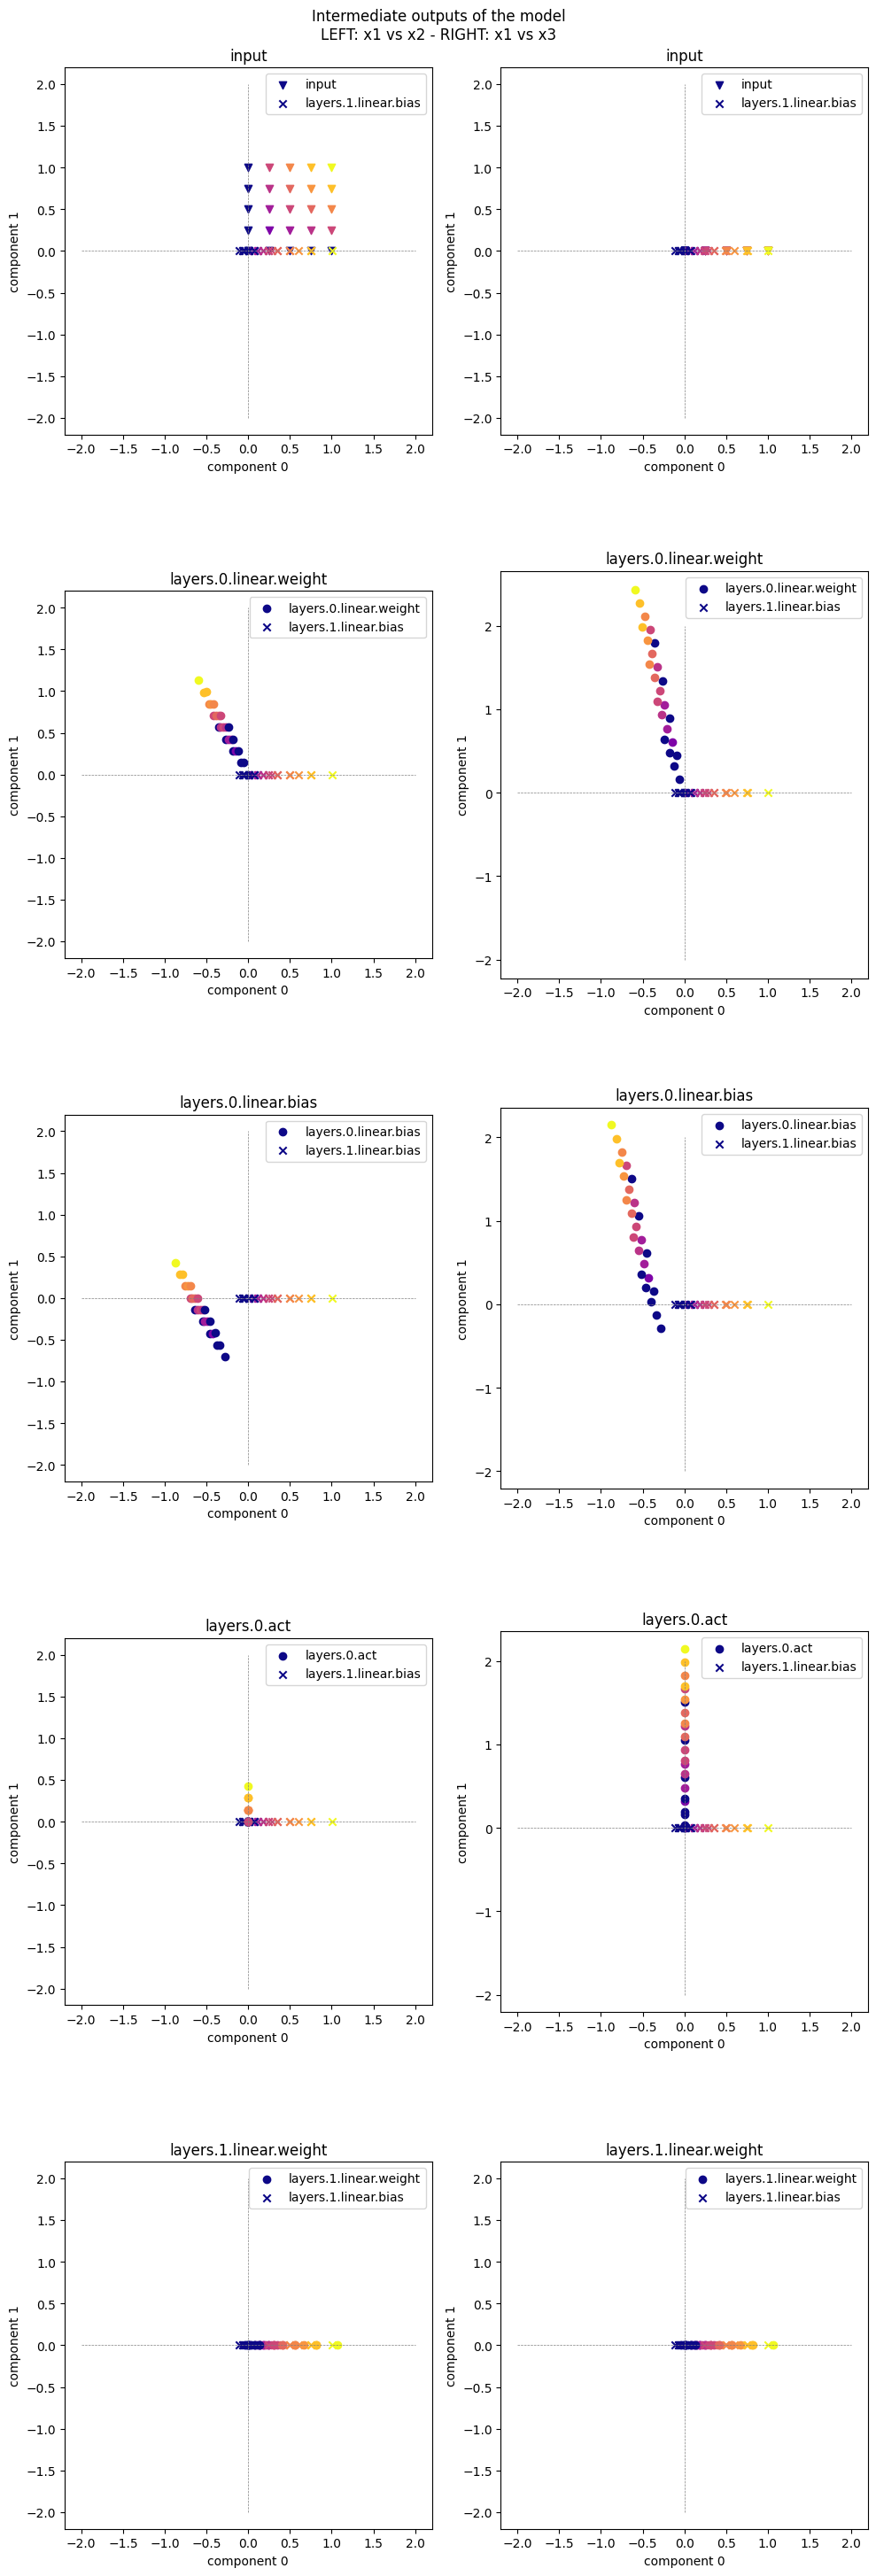

In [18]:
fig, axes = plt.subplots(5, 2, figsize=(10, 30))

dims = [(0, 1), (0, 2)]

plot_subsets(dim1=dims[0][0], dim2=dims[0][1], axes=axes[:, 0])
plot_subsets(dim1=dims[1][0], dim2=dims[1][1], axes=axes[:, 1])

fig.suptitle(
    f"Intermediate outputs of the model\nLEFT: x{dims[0][0]+1} vs x{dims[0][1]+1} - RIGHT: x{dims[1][0]+1} vs x{dims[1][1]+1}"
)
fig.tight_layout()

/var/folders/5z/c8p82vrj5f333s_5w192fbw80000gn/T/ipykernel_89904/3393814815.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rectangle in which to fit the subplots


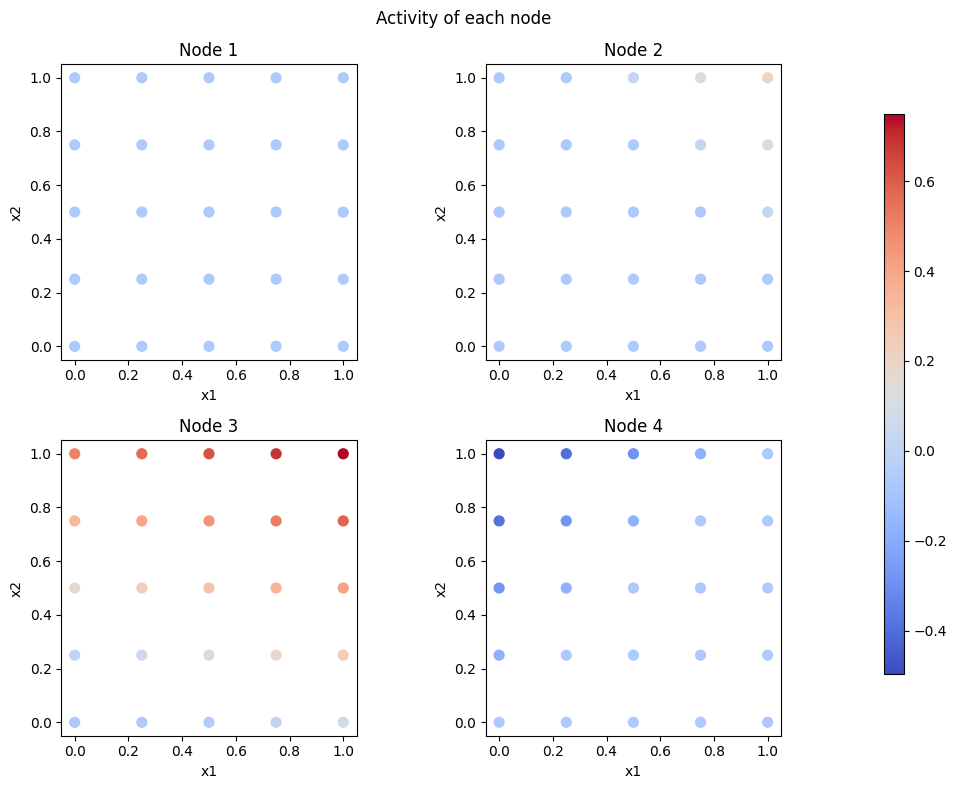

In [19]:
N = 5
eps = 0.05
pairs = np.concatenate(np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T)

outputs = capture_intermediate_outputs(model, torch.as_tensor(pairs).float())
lws = model.state_dict()["layers.1.linear.weight"]
acts = outputs["layers.0.act"]
acts = acts * lws[0, :]  # linear weighting now (I know they're not technically activations anymore)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # Increase the width to make space for the colorbar
axes = axes.flatten()

# Determine global min and max activations to ensure consistent colour scaling
vmin, vmax = acts.min(), acts.max()

for i in range(acts.shape[1]):
    col = acts[:, i]
    activated_mask = acts[:, i].abs() > eps  # really trying to focus on the activated areas
    activated_mask = torch.ones(col.shape, dtype=bool)
    sc = axes[i].scatter(
        pairs[activated_mask, 0],
        pairs[activated_mask, 1],
        c=col[activated_mask],
        cmap="coolwarm",
        s=50,
        norm=plt.Normalize(vmin=vmin, vmax=vmax),
    )

    axes[i].set_title(f"Node {i+1}")
    axes[i].set_xlabel("x1")
    axes[i].set_ylabel("x2")
    axes[i].set_aspect("equal")
    axes[i].set_xlim(-0.05, 1.05)
    axes[i].set_ylim(-0.05, 1.05)

# Position the colorbar on the right of the last subplot
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(sc, cax=cbar_ax)

fig.suptitle("Activity of each node")
fig.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rectangle in which to fit the subplots

Things of note across these resulting (more optimal) networks:
- always seems to be one mode mainly doing the heavy lifting and then others making finer adjustments - wonder if there are any power law scalings here?
- often there's one node really not doing much at all - similar point to above
- I wonder if there's something to do with gradients here where the node which is initialised closest to an optimal transform can take the brunt of the optimisation whereas the others come in to deal with the finer detail?

In [20]:
# torch.save(model.state_dict(), 'models/e-4-.pth')